In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
from models.gru import GRU

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust8-30"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
clust_mode = "hand"
model_type = "gru"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)

if (clust_mode == "hand") or (clust_mode == "whole"):
    C_syn_e = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/handsub14_C_syn_e.npy")
    C_syn_i = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/handsub14_C_syn_i.npy")
    C_syn_e = torch.from_numpy(C_syn_e).float()
    C_syn_i = torch.from_numpy(C_syn_i).float()
elif clust_mode == "rand":
    C_syn_e = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/randsub14_C_syn_e.npy")
    C_syn_i = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/randsub14_C_syn_i.npy")
    C_syn_e = torch.from_numpy(C_syn_e).float()
    C_syn_i = torch.from_numpy(C_syn_i).float()

In [4]:
H_no = 20
sub_no = 14
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

In [5]:
if model_type == "gru":
    model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
elif model_type == "tcn":
    model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
elif model_type == "glm":
    model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
    
model.to(device).float()
model.load_state_dict(torch.load(base_dir+cell_type+"_"+experiment+"/"+clust_mode+"/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+".pt", map_location='cuda:0'))
model.eval()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

21815


In [11]:
C_syn_e = np.load("/media/hdd01/sklee/CA1_clust8-30/data/handsub14_C_syn_e.npy")
syn_list = np.empty((13))
for i in range(13):
    sub_idx = np.where(np.argmax(C_syn_e, 0) == i+1)[0]
    syn = np.random.choice(sub_idx)
    if i >= 5:
        #syn_list[i-5] = int(syn)
        syn_list[i-5] = 880 + (i-4)*30 - 3
    else:
        syn_list[i+8] = int(syn)
syn_list = syn_list.astype(int)
print(syn_list)
for i in range(syn_list.shape[0]):
    print(np.argmax(C_syn_e[:,syn_list[i]]))


[ 907  937  967  997 1027 1057 1087 1117  325 1919  825 1239  251]
6
8
10
12
9
11
7
13
1
2
3
4
5


In [13]:
final_test = np.zeros((13,3,30,6000))
#syn_list = np.asarray([ 977,  997, 1017, 1037, 1057, 1077 ,1097, 1117 ,1137, 1157 ,1177 ,
                       #1197, 1287,  603, 733,  630, 1418])
syn_list = np.asarray([ 907 , 937  ,967,  997, 1027, 1057, 1087 ,1117  ,325 ,1919,
                       825, 1239 , 251])

for i in tnrange(syn_list.shape[0]):
    syn = syn_list[i]
    for j in range(3):
        for k in range(30):
            E_in = torch.zeros(1,6000,2000).cuda()
            I_in = torch.zeros(1,6000,200).cuda()
            
            if j == 0:
                spk_times = np.arange(500,500+10*(k+1),10)
            elif j == 1:
                spk_times = np.arange(500,500+50*(k+1),50)
            elif j == 2:
                spk_times = np.arange(500,500+150*(k+1),150)
            
            E_in[0, spk_times ,syn] = 1
            test, sub_out = model(E_in, I_in)
            final_test[i,j,k] = test.cpu().detach().numpy()

<ipython-input-13-3bf5f65da84f>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(syn_list.shape[0]):


  0%|          | 0/13 [00:00<?, ?it/s]

In [5]:
final_test = np.zeros((8,3,30,6000))

syn_list = [821, 580, 1211, 692]

for i in tnrange(8):
    if i == 0:
        syn = 930
    elif i == 1:
        syn = 990
    elif i == 2:
        syn = 1050
    elif i == 3:
        syn = 1110
    else:
        syn = syn_list[i-4]
    
    for j in range(3):
        for k in range(30):
            E_in = torch.zeros(1,6000,2000).cuda()
            I_in = torch.zeros(1,6000,200).cuda()
            
            if j == 0:
                spk_times = np.arange(500,500+10*(k+1),10)
            elif j == 1:
                spk_times = np.arange(500,500+50*(k+1),50)
            elif j == 2:
                spk_times = np.arange(500,500+150*(k+1),150)
            
            E_in[0, spk_times ,syn] = 1
            test, sub_out = model(E_in, I_in)
            final_test[i,j,k] = test.cpu().detach().numpy()

<ipython-input-5-81a28a7e4a95>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(8):


  0%|          | 0/8 [00:00<?, ?it/s]

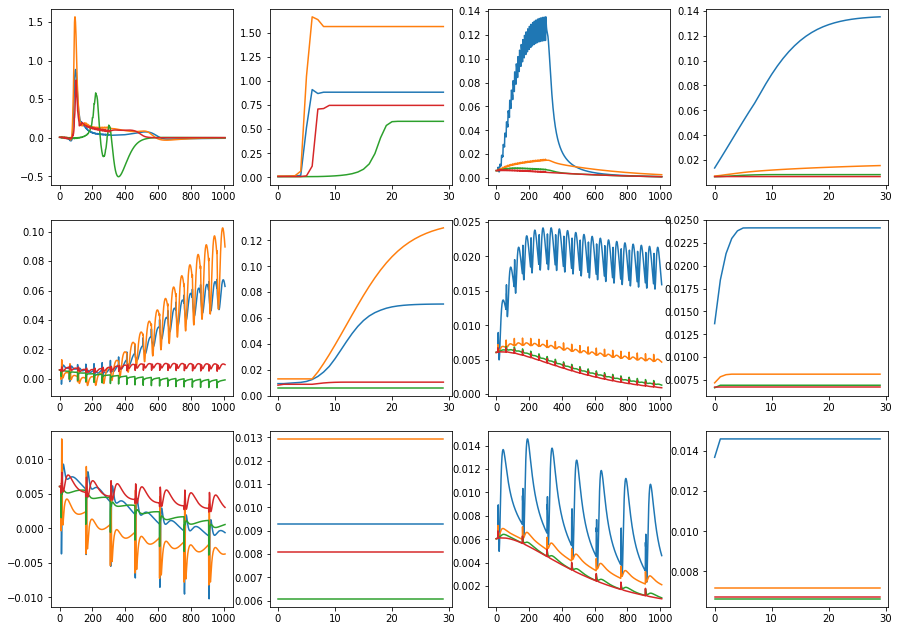

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (15,11))

for i in range(3):
    for j in range(4):
            axs[i,0].plot(final_test[j,i,-1,490:1500])
            axs[i,1].plot(np.max(final_test[j,i,:,490:], 1))
            
            axs[i,2].plot(final_test[j+4,i,-1,490:1500])
            axs[i,3].plot(np.max(final_test[j+4,i,:,490:], 1))

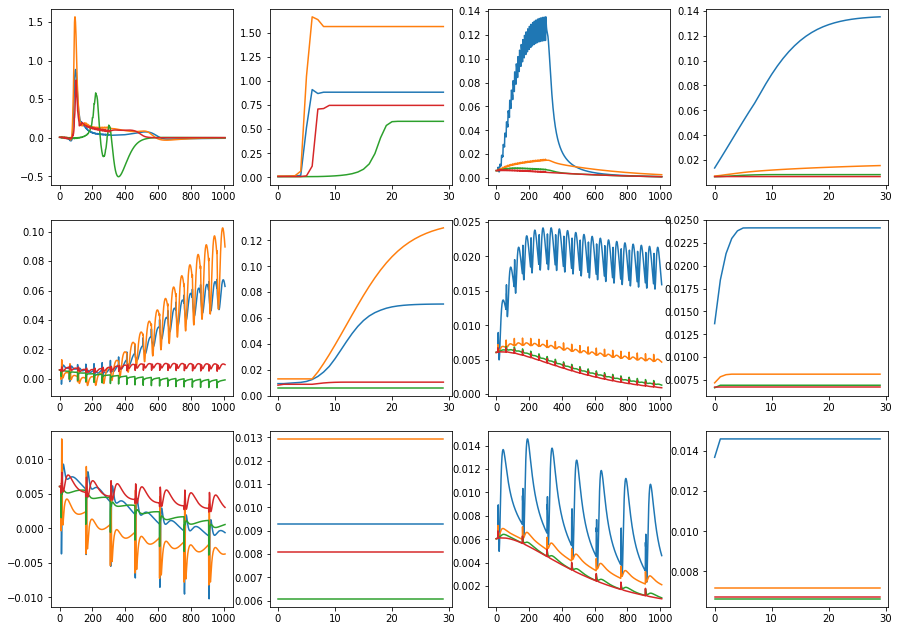

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (15,11))

for i in range(3):
    for j in range(4):
            axs[i,0].plot(final_test[j,i,-1,490:1500])
            axs[i,1].plot(np.max(final_test[j,i,:,490:], 1))
            
            axs[i,2].plot(final_test[j+4,i,-1,490:1500])
            axs[i,3].plot(np.max(final_test[j+4,i,:,490:], 1))

In [14]:
#np.save("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s14_h20_probe.npy", final_test)